## 0. Introduction - KNN GE-ML

Grupo de Estudos - Machine Learning (Study Group from Comunidade DS)

Book: Introduction to Machine Learning with Python by Andreas Müller & Sarah Guido

## 1. Imports

In [65]:
import os
import random
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, StratifiedGroupKFold

from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier, KNeighborsTransformer, RadiusNeighborsTransformer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, f1_score

from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

In [39]:
def jupyter_settings():
    %matplotlib inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
#     display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
jupyter_settings() 

## 2. Reading Data

In [16]:
train = pd.read_csv("ge-ml-cds-knn/train.csv", index_col='id')
test = pd.read_csv("ge-ml-cds-knn/test.csv", index_col='id')
ss = pd.read_csv("ge-ml-cds-knn/sample_submission.csv")

print("Train shape:\t{}".format(train.shape))
print("Test shape:\t{}".format(test.shape))
print("Sub shape:\t{}".format(ss.shape))

Train shape:	(3428, 12)
Test shape:	(1470, 11)
Sub shape:	(1470, 2)


In [218]:
test_for_df = pd.read_csv("ge-ml-cds-knn/test.csv")

In [17]:
train.head(2)

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,target
id,,,,,,,,,,,,
3009,0.259615,0.117647,0.301205,0.268405,0.133531,0.167247,0.491879,0.237131,0.200000,0.488372,0.129032,1
4885,0.269231,0.254902,0.240964,0.115031,0.109792,0.229965,0.373550,0.150954,0.390909,0.325581,0.250000,1


## 3. Seed

In [210]:
class CFG:
    seed = 42
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(seed = CFG.seed)

## 4. EDA

### Obtaining overall information


In [28]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3428 entries, 3009 to 3115
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      3428 non-null   float64
 1   x2      3428 non-null   float64
 2   x3      3428 non-null   float64
 3   x4      3428 non-null   float64
 4   x5      3428 non-null   float64
 5   x6      3428 non-null   float64
 6   x7      3428 non-null   float64
 7   x8      3428 non-null   float64
 8   x9      3428 non-null   float64
 9   x10     3428 non-null   float64
 10  x11     3428 non-null   float64
 11  target  3428 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 348.2 KB


### Checking target balance

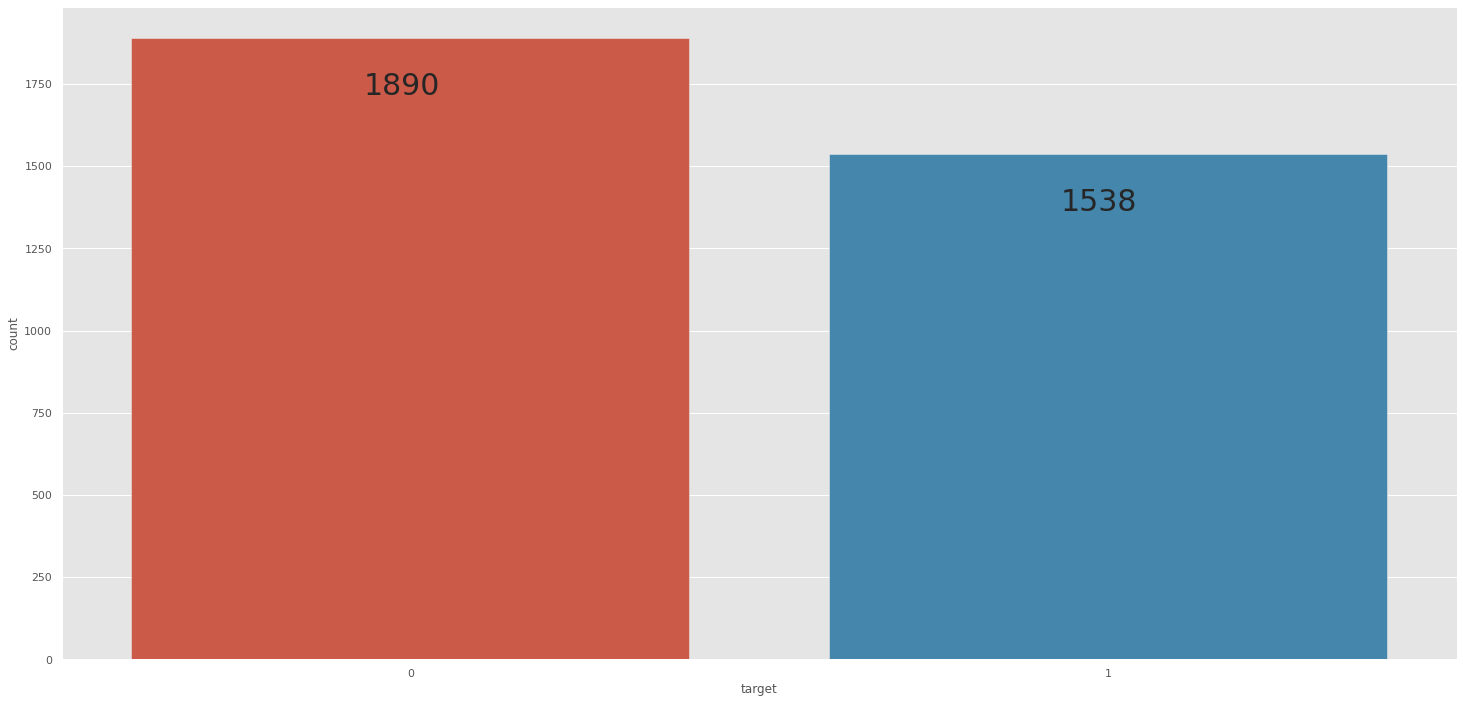

In [53]:
g = sns.countplot(x=train['target'])
g.set_xticklabels(['0','1'])
for p in g.patches:
    g.annotate('\n{:.0f}'.format(p.get_height()), (p.get_x()+0.387, p.get_height()), ha='center', va='top', size=30)
plt.show()

### Checking Distributions

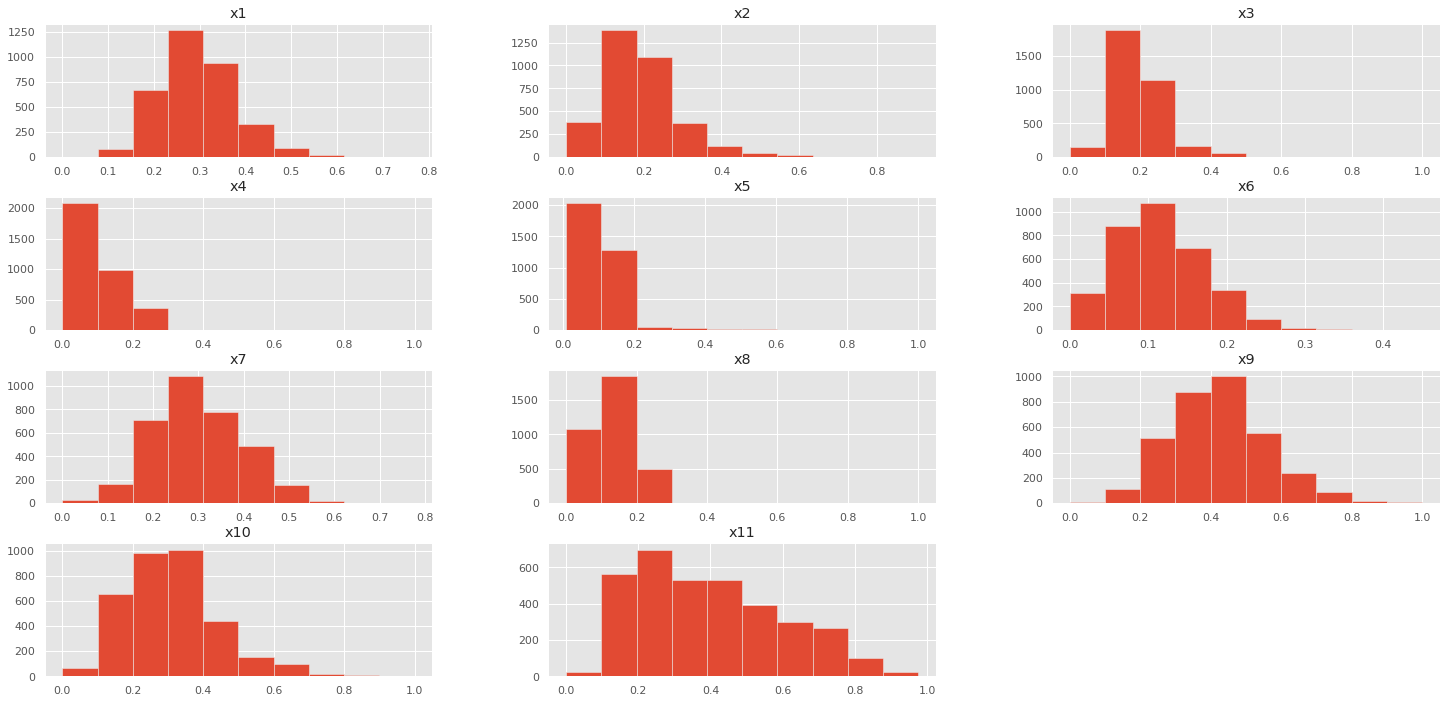

In [43]:
train.drop('target', axis=1).hist();

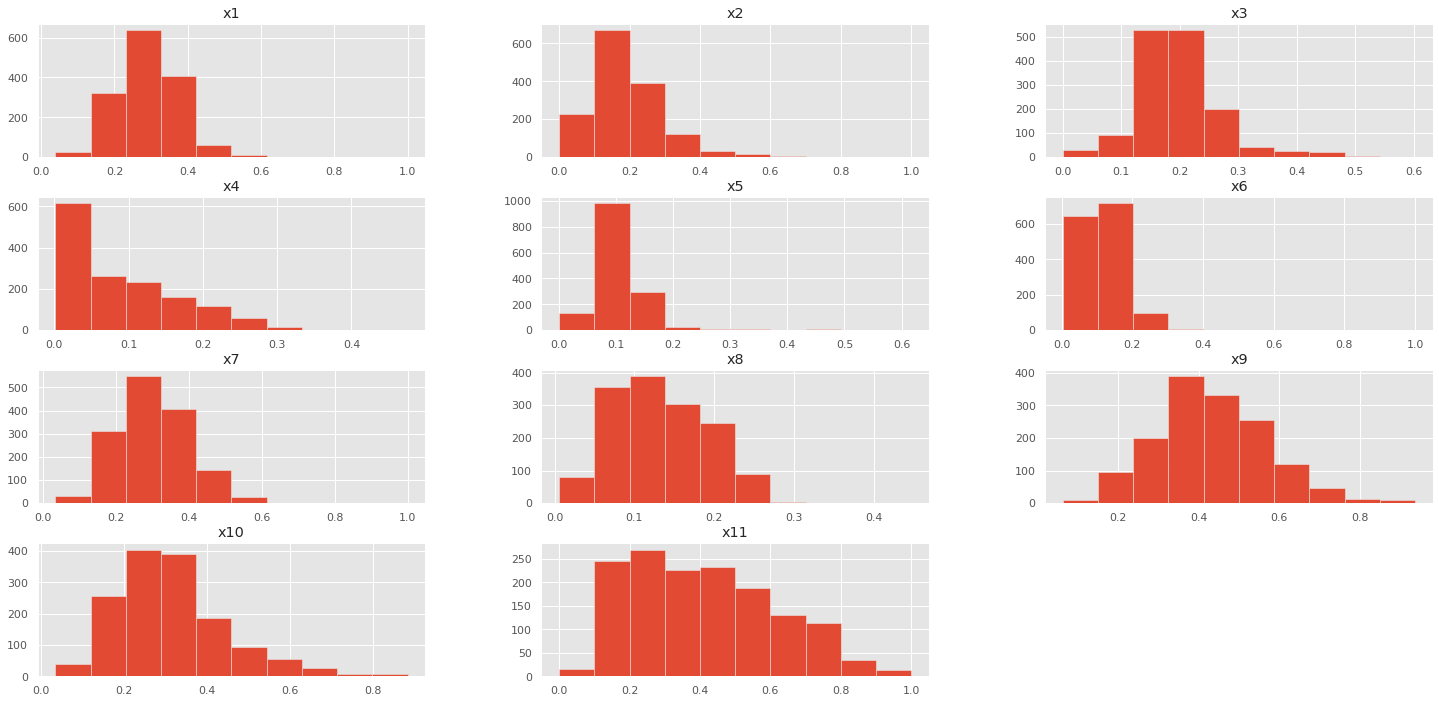

In [44]:
test.hist();

### Checking correlations

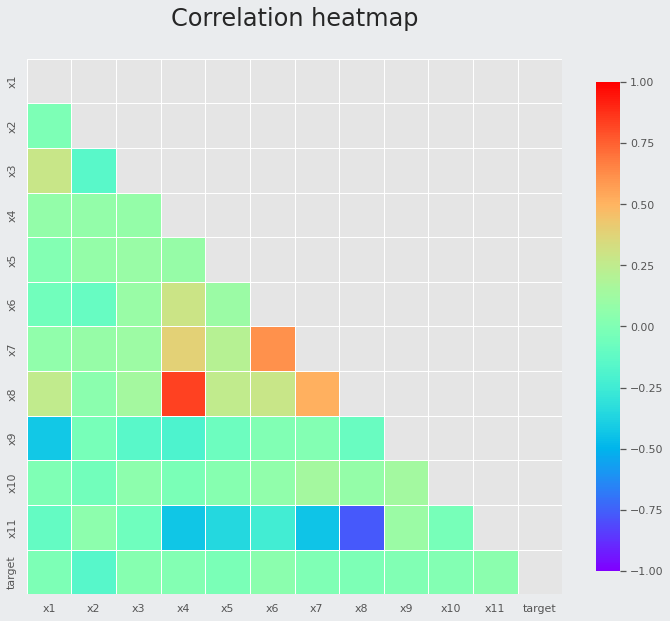

In [59]:
corr = train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(12, 12), facecolor='#EAECEE')
cmap = sns.color_palette("rainbow", as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1., center=0, annot=False,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.75})

ax.set_title('Correlation heatmap', fontsize=24, y= 1.05)
colorbar = ax.collections[0].colorbar

* Plotted the correlation heatmap to get a global idea of what features might be related to each other and may lead us to some feature engineering.
* We see two groups where feature-to-feature correlation might exist:
    * `x4` and `x8` seems to be highly correlated, as well as `x8` and `x11`, but in an inverse way
    * There seem to be also a significant correlation between `x6` and `x7`

In [171]:
train.corr()['target'].sort_values()

x2       -0.161901
x5       -0.015934
x8       -0.009401
x1       -0.008533
x7       -0.000649
x9        0.001657
x10       0.012225
x4        0.012936
x3        0.027648
x6        0.041567
x11       0.042281
target    1.000000
Name: target, dtype: float64

### Scaling

Scaling is useful for rearranging the *range* of our data when they are not similar, which is not the case in this problem.

In [47]:
# scale_feats = [col for col in train.columns if train[col].dtypes == 'float64']
# scaler = StandardScaler()

# train_scaled = train.copy()
# test_scaled = test.copy()

# train_scaled[scale_feats] = scaler.fit_transform(train[scale_feats])
# test_scaled[scale_feats] = scaler.transform(test[scale_feats])

## 5. Modeling

In [63]:
X = train.drop('target', axis=1)
y = train['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2) # random_state already stated at CFG.seed

Start evaluating our models with default parameters.

In [115]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_pred_knn = model_knn.predict(X_test)
score_knn = model_knn.score(X_test, y_test)
print("Accuracy: {:.5f}".format(score_knn))

Accuracy: 0.61808


In [118]:
model_rnn = RadiusNeighborsClassifier(radius=2) # radius 1 was not working!
model_rnn.fit(X_train, y_train)

y_pred_rnn = model_knn.predict(X_test)
score_rnn = model_rnn.score(X_test, y_test)
print("Accuracy: {:.5f}".format(score_rnn))

Accuracy: 0.56414


Let's proceed with KNeighborsClassifier.

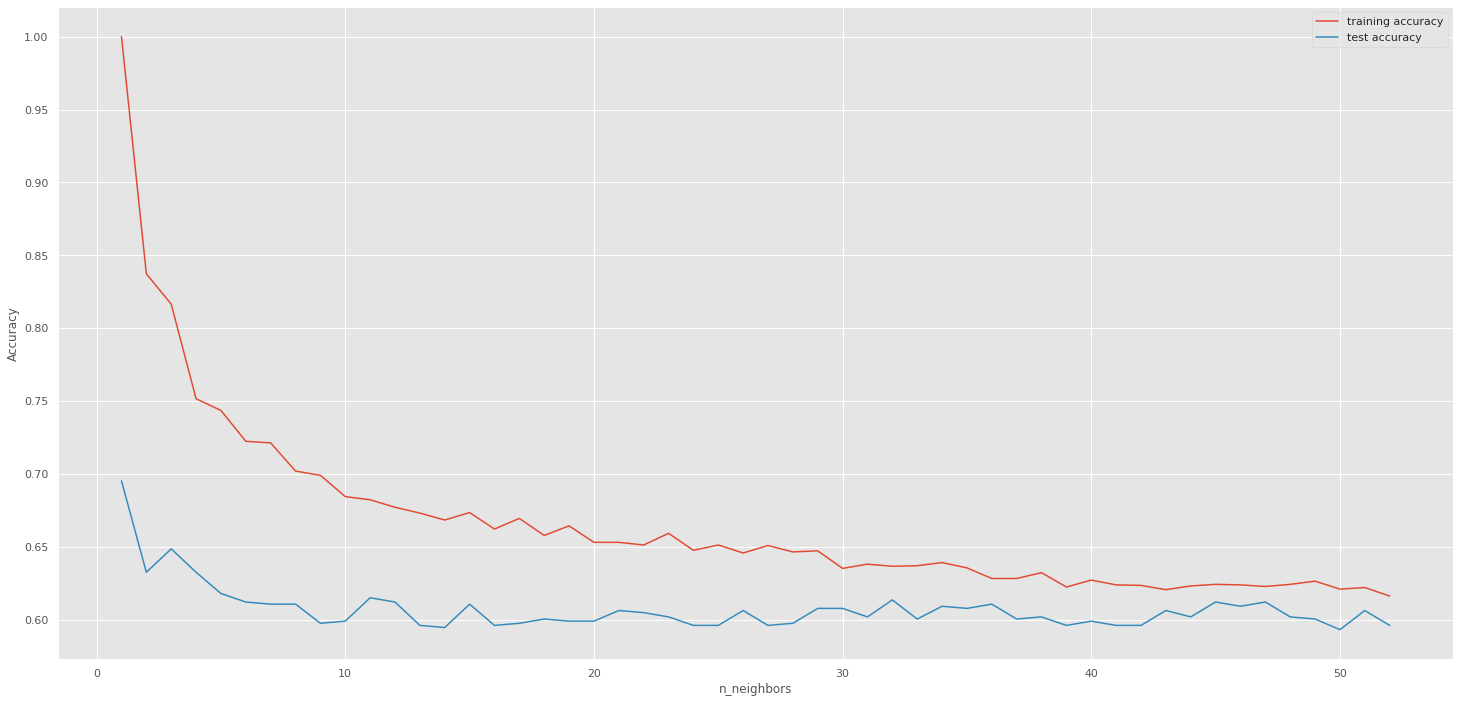

In [152]:
training_accuracy = []
test_accuracy = []
error_rate = []
neighbors_settings = range(1, round(X_train.shape[0]**(1/2))+1)

for n_neighbors in neighbors_settings:
    # build the model
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(X_train, y_train)
     # record training set accuracy
    training_accuracy.append(clf.score(X_train, y_train))
     # record generalization accuracy
    test_accuracy.append(clf.score(X_test, y_test))
    # store error
    pred_i = clf.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))
    
    
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()
plt.show()

Minimum error:- 0.30466472303207 at K = 1


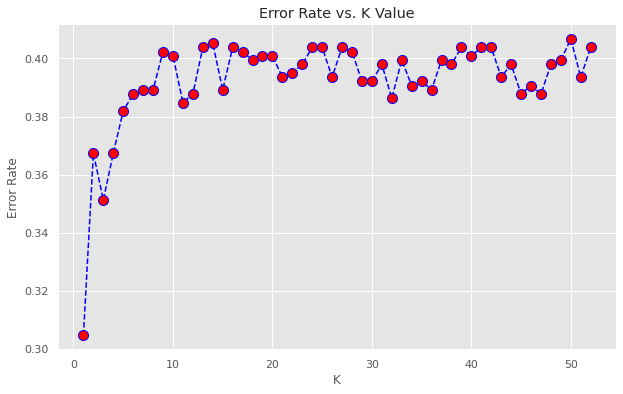

In [153]:
plt.figure(figsize=(10,6))
plt.plot(range(1,53), error_rate, color='blue', linestyle='dashed',marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
req_k_value = error_rate.index(min(error_rate))+1
print("Minimum error:-", min(error_rate),"at K =", req_k_value)

In [60]:
METRICS = ['cityblock', 
           'cosine', 
           'euclidean',
#            'haversine', 'seuclidean', COMPUTA NAN
#            'mahalanobis', COMPUTA NAN PARA TEST
           'minkowski',   # bom valor de treino
#            'precomputed', DA ERRO NESSA
           'sqeuclidean', # bom valor de test
           'l1', 'l2', 'manhattan',
           'nan_euclidean', 'hamming', 'braycurtis',
           'canberra', 'chebyshev', 'correlation',
           'dice', 'jaccard', 'kulsinski', 
           'yule', 'matching', 'rogerstanimoto',
           'russellrao', 'sokalmichener',  'sokalsneath']

Usually, the optimal K value found is the square root of N, where N is the total number of samples.

In [141]:
K_optimal = round(X_train.shape[0]**(1/2))
K_optimal

52

Since this is an even number, we are going to add 1 to make it odd (better fit for K).

In [127]:
model_knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [142]:
%%time

knn = KNeighborsClassifier()
params = {
    'algorithm': ['auto'],
    'leaf_size': [5, 10, 20, 30],
    'metric': ['euclidean', 'minkowski', 'sqeuclidean', 'canberra', 'manhattan', 'cosine'],
    'n_neighbors': np.arange(1, K_optimal+1, 2).tolist(),
    'weights': ['uniform', 'distance'] 
        }

gs = GridSearchCV(knn, params, cv=5, refit=True, scoring='roc_auc', verbose=True)
gs.fit(X_train, y_train)

print("best parameters: ",gs.best_params_)
print("best score: ", gs.best_score_)

Fitting 5 folds for each of 1248 candidates, totalling 6240 fits
best parameters:  {'algorithm': 'auto', 'leaf_size': 5, 'metric': 'sqeuclidean', 'n_neighbors': 51, 'weights': 'distance'}
best score:  0.755385766337478
CPU times: user 3min 13s, sys: 2min 37s, total: 5min 50s
Wall time: 2min 16s


In [143]:
%%time

knn = KNeighborsClassifier()
params = {
    'algorithm': ['auto'],
    'leaf_size': [5, 10, 15, 20, 25, 30],
    'metric': ['euclidean', 'minkowski', 'sqeuclidean', 'canberra', 'manhattan', 'cosine'],
    'n_neighbors': np.arange(1, K_optimal+1, 2).tolist(),
    'weights': ['uniform', 'distance'] 
        }

gs = GridSearchCV(knn, params, cv=5, refit=True, scoring='accuracy', verbose=True)
gs.fit(X_train, y_train)

print("best parameters: ",gs.best_params_)
print(f"best score: {:.5f}", gs.best_score_)

Fitting 5 folds for each of 1872 candidates, totalling 9360 fits
best parameters:  {'algorithm': 'auto', 'leaf_size': 5, 'metric': 'sqeuclidean', 'n_neighbors': 33, 'weights': 'distance'}
best score: {:.5f} 0.6779758818289392
CPU times: user 5min 42s, sys: 5min 4s, total: 10min 46s
Wall time: 3min 53s


In [177]:
model_temp = gs.best_estimator_
model_temp

KNeighborsClassifier(leaf_size=5, metric='sqeuclidean', n_neighbors=33,
                     weights='distance')

In [179]:
preds_temp = model_temp.predict(X_test)

In [180]:
accuracy_score(y_test, preds_temp)

0.6953352769679301

### Making a Submission with this first model

In [156]:
preds = gs.best_estimator_.predict(test)

In [157]:
ss['target'] = preds
ss.to_csv('submission.csv', index=False)

## 6. Cross-Validation KFold

In [171]:
train.corr()['target'].sort_values()

x2       -0.161901
x5       -0.015934
x8       -0.009401
x1       -0.008533
x7       -0.000649
x9        0.001657
x10       0.012225
x4        0.012936
x3        0.027648
x6        0.041567
x11       0.042281
target    1.000000
Name: target, dtype: float64

In [292]:
FOLDS = 5
TARGET = 'target'

FEATURES = [
            'x1', 
            'x2', 
            'x3', 
            'x4', 
            'x5', 
            'x6', 
            'x7', 
#             'x8', dropping cause high correlated with x4 and x11
            'x9', 
            'x10', 
            'x11'  
]

In [293]:
%%time
df_sub = test_for_df[['id']].copy()
aucs = []
accs = []
preds_test_roc = []
preds_test = []
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=CFG.seed)

for fold, (tr_idx, val_idx) in enumerate(kf.split(train[FEATURES],train['target'])):
  
    X_tr = train.iloc[tr_idx][FEATURES]
    X_va = train.iloc[val_idx][FEATURES]
    y_tr = train.iloc[tr_idx]['target']
    y_va = train.iloc[val_idx]['target']

#     model = KNeighborsClassifier()
    model = gs.best_estimator_


    # Register Feature Importances
    model.fit(X_tr, y_tr)

    # Validate model
    va_preds = model.predict_proba(X_va)[:,1]
    roc_score = roc_auc_score(y_va, va_preds)
    score = model.score(X_va, y_va)
    print(f"Fold {fold}: auc = {roc_score:.5f}, accuracy = {score:.5f}")
    aucs.append(roc_score)
    accs.append(score)

    # Test set predictions
    preds_test_roc.append(model.predict_proba(test[FEATURES])[:,1])
    preds_test.append(model.predict(test[FEATURES]))

    df_sub[f'fold_{fold}'] = preds_test[fold]
    
print(f'\nAverage AUC = {sum(aucs) / len(aucs):.5f}')
print(f'\nAverage Accuracy = {sum(accs) / len(accs):.5f}')
print('')
preds = sum(preds_test)/len(preds_test)

Fold 0: auc = 0.79745, accuracy = 0.70117
Fold 1: auc = 0.77078, accuracy = 0.66764
Fold 2: auc = 0.80278, accuracy = 0.70554
Fold 3: auc = 0.77915, accuracy = 0.69197
Fold 4: auc = 0.78461, accuracy = 0.70365

Average AUC = 0.78695

Average Accuracy = 0.69399

CPU times: user 706 ms, sys: 1.91 ms, total: 708 ms
Wall time: 705 ms


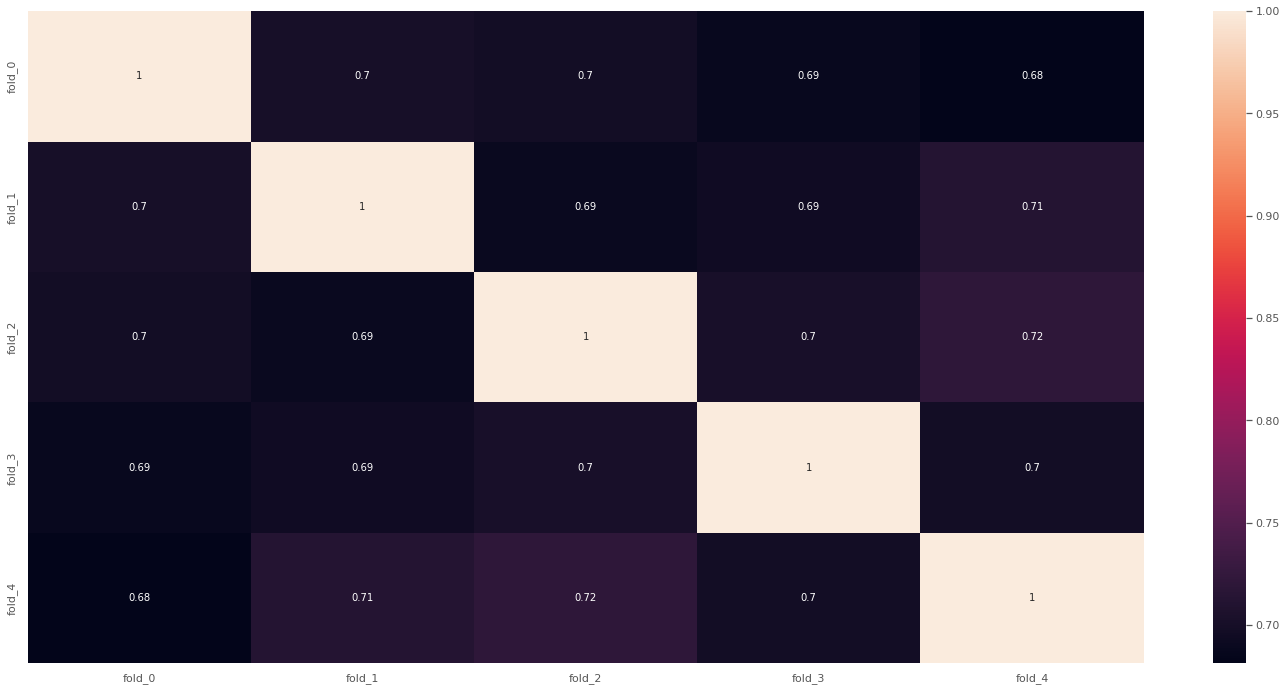

In [294]:
pred_cols = [x for x in df_sub.columns if x.startswith('fold_')]

df_sub['target'] = round(df_sub[pred_cols].mean(axis=1))

# Visually check correlation between fold predictions
sns.heatmap(df_sub[pred_cols].corr(), annot=True);

## 7. Submission

In [295]:
df_sub['target'] = df_sub['target'].astype('int64')
df_sub.head()

,id,fold_0,fold_1,fold_2,fold_3,fold_4,target
0,4325,0,0,0,0,0,0
1,4200,1,1,1,1,1,1
2,4273,1,1,1,1,1,1
3,4337,0,0,0,0,0,0
4,2615,0,0,0,0,0,0
5,3574,1,1,1,1,1,1
6,2800,0,0,0,0,0,0
7,1455,0,0,0,0,0,0
8,3394,0,0,0,0,0,0
9,833,1,1,1,1,1,1


In [296]:
df_sub[['id', 'target']]

,id,target
0,4325,0
1,4200,1
2,4273,1
3,4337,0
4,2615,0
5,3574,1
6,2800,0
7,1455,0
8,3394,0
9,833,1


In [297]:
df_sub[['id', 'target']].to_csv('submission_cv3.csv', index=False)